In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load the dataset
df = pd.read_csv("/kaggle/input/data-storm-6-0/train_storming_round.csv")
test_df = pd.read_csv("/kaggle/input/data-storm-6-0/test_storming_round.csv")

In [7]:
# 2. Basic cleaning
row_ids = test_df['row_id']
df = df.drop(columns=['row_id', 'agent_code'], errors='ignore')
test_df = test_df.drop(columns=['row_id', 'agent_code'], errors='ignore')

In [8]:

# Ensure 'agent_join_month' and 'first_policy_sold_month' are in datetime format
df['agent_join_month'] = pd.to_datetime(df['agent_join_month'], errors='coerce')
df['first_policy_sold_month'] = pd.to_datetime(df['first_policy_sold_month'], errors='coerce')

# Fill missing values with the mode (most frequent value) of each column
df['agent_join_month'].fillna(df['agent_join_month'].mode()[0], inplace=True)
df['first_policy_sold_month'].fillna(df['first_policy_sold_month'].mode()[0], inplace=True)

# Get the current year dynamically
current_year = pd.Timestamp.now().year
current_month=pd.Timestamp.now().month
print(current_year)

# Calculate agent experience in months
df['agent_experience_months'] = (current_year - df['agent_join_month'].dt.year) * 12 + (current_month - df['agent_join_month'].dt.month)

# Calculate policy lifetime in months
df['policy_lifetime_months'] = (current_year - df['first_policy_sold_month'].dt.year) * 12 + (current_month - df['first_policy_sold_month'].dt.month)

# Display the updated dataframe
print(df[[ 'agent_experience_months', 'policy_lifetime_months']])


2025
       agent_experience_months  policy_lifetime_months
0                           51                      20
1                           37                      15
2                           60                      20
3                           70                      38
4                           56                      27
...                        ...                     ...
15303                       73                      19
15304                       32                      14
15305                       52                      13
15306                       41                      17
15307                       28                      15

[15308 rows x 2 columns]


/tmp/ipykernel_31/1981754305.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['agent_join_month'].fillna(df['agent_join_month'].mode()[0], inplace=True)
/tmp/ipykernel_31/1981754305.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [11]:
test_df['agent_join_month'] = pd.to_datetime(test_df['agent_join_month'], errors='coerce')
test_df['first_policy_sold_month'] = pd.to_datetime(test_df['first_policy_sold_month'], errors='coerce')

# Fill missing values with the mode (most frequent value) of each column
test_df['agent_join_month'].fillna(test_df['agent_join_month'].mode()[0], inplace=True)
test_df['first_policy_sold_month'].fillna(test_df['first_policy_sold_month'].mode()[0], inplace=True)

test_df['agent_experience_months'] = (current_year - test_df['agent_join_month'].dt.year) * 12 + (current_month - test_df['agent_join_month'].dt.month)

# Calculate policy lifetime in months
test_df['policy_lifetime_months'] = (current_year - test_df['first_policy_sold_month'].dt.year) * 12 + (current_month - test_df['first_policy_sold_month'].dt.month)

# Display the updated dataframe
print(test_df[[ 'agent_experience_months', 'policy_lifetime_months']])


     agent_experience_months  policy_lifetime_months
0                         59                      37
1                         72                      33
2                         71                      35
3                         48                      20
4                         32                      18
..                       ...                     ...
909                       60                      40
910                       43                      30
911                       34                      22
912                       48                      23
913                       57                      29

[914 rows x 2 columns]


/tmp/ipykernel_31/688571032.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['agent_join_month'].fillna(test_df['agent_join_month'].mode()[0], inplace=True)
/tmp/ipykernel_31/688571032.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

In [12]:
df.head()

,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,unique_quotations_last_15_days,...,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,agent_experience_months,policy_lifetime_months
0,45,2021-02-01,2023-09-01,1/1/2023,3,6,2,12,3,0,...,4,8,15,0,0,93313,30,162,51,20
1,48,2022-04-01,2024-02-01,1/1/2023,1,4,12,21,3,1,...,3,10,17,25,1071450,164804,0,175,37,15
2,53,2020-05-01,2023-09-01,1/1/2023,3,5,5,17,1,6,...,7,11,21,26,1601210,426690,84,78,60,20
3,44,2019-07-01,2022-03-01,1/1/2023,1,0,12,17,1,1,...,2,9,13,18,283230,47793,39,144,70,38
4,20,2020-09-01,2023-02-01,1/1/2023,0,6,10,17,3,6,...,10,6,19,20,1957680,562239,19,40,56,27


In [13]:
test_df.head()

,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,unique_quotations_last_7_days,unique_quotations_last_15_days,...,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,agent_experience_months,policy_lifetime_months
0,43,2020-06-01,2022-04-01,9/1/2024,0,2,12,17,4,5,...,9,5,20,24,511320,86955,0,48,59,37
1,32,2019-05-01,2022-08-01,9/1/2024,1,3,4,13,0,1,...,2,5,9,14,296660,55062,9,56,72,33
2,52,2019-06-01,2022-06-01,9/1/2024,2,6,17,27,3,4,...,6,10,21,34,833544,224429,0,34,71,35
3,21,2021-05-01,2023-09-01,9/1/2024,1,6,17,26,3,1,...,2,10,15,33,2972409,439159,15,33,48,20
4,33,2022-09-01,2023-11-01,9/1/2024,0,4,2,8,3,4,...,4,6,15,15,168150,18195,60,90,32,18


In [14]:
df.shape

(15308, 23)

In [15]:
test_df.shape

(914, 23)

In [16]:
# 6. Drop unused columns
df.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'], inplace=True)
test_df.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'], inplace=True)

In [19]:
# 3. Define target
df['target'] = (df['new_policy_count'] > 10).astype(int)
df.drop(columns=['new_policy_count'], inplace=True)

test_df['target'] = (test_df['new_policy_count'] > 0).astype(int)
test_df.drop(columns=['new_policy_count'], inplace=True)



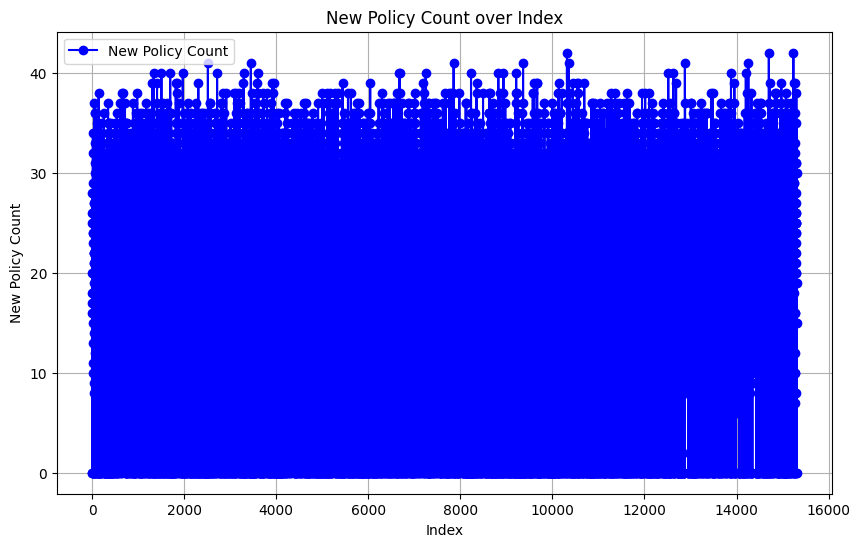

In [18]:
import matplotlib.pyplot as plt

# Plotting the 'new_policy_count' column
plt.figure(figsize=(10,6))
plt.plot(df['new_policy_count'], marker='o', linestyle='-', color='b', label='New Policy Count')
plt.xlabel('Index')
plt.ylabel('New Policy Count')
plt.title('New Policy Count over Index')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# 4. Feature & target split
X_train = df.drop(columns=['target'])
y_train = df['target']
X_test = test_df.drop(columns=['target'], errors='ignore')

In [31]:
X_train_scaled.shape

(15308, 19)

In [35]:
print(X_train.shape)  # Should be (12246, n_features)
print(y_train.shape)  # Should be (12246,)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Check if the shapes match after scaling
print(X_train_scaled.shape)  # Should be (12246, n_features)
print(y_train.shape)         # Should still be (12246,)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred


(12246, 19)
(12246,)
(12246, 19)
(12246,)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Step 1: Split your data into training and validation sets
from sklearn.model_selection import train_test_split

# Assuming train_df is your dataframe
X = df.drop('target', axis=1)  # Replace 'target_column' with the actual name
y = df['target']  # Replace 'target_column' with the actual name

# Split into 80% train and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Import necessary models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Step 3: Train different models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Step 4: Evaluate models on the validation set
from sklearn.metrics import accuracy_score

best_model = None
best_accuracy = 0

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


# # Step 5: Apply the best model to the test data (test_df)
# X_test = test_df.drop('target_column', axis=1)  # Replace 'target_column' with the actual name
# y_test = test_df['target_column']  # Replace 'target_column' with the actual name

# # Predict on the test data
# y_test_pred = best_model.predict(X_test)

# # You can also evaluate the model's performance on the test data
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Best Model Test Accuracy: {test_accuracy:.4f}")


Random Forest Accuracy: 0.5046


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.5444
Support Vector Classifier Accuracy: 0.4791
K-Nearest Neighbors Accuracy: 0.5314
Decision Tree Accuracy: 0.5029


In [ ]:
# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [27]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [15308, 12246]

In [ ]:
predictions = model.predict(X_test_scaled)
print("Predictions on test set:", predictions)

Predictions on test set: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1


In [ ]:
# Predict on test data
y_pred = model.predict(X_test_scaled)
y_test = test_df['target']  # true labels

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


[[ 94   0]
 [  0 820]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00       820

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914

Accuracy: 1.0


In [38]:
submission = pd.DataFrame({
    'row_id': row_ids,
    'target_column': y_pred
})

# Save to CSV
submission.to_csv("submission-1.csv", index=False)

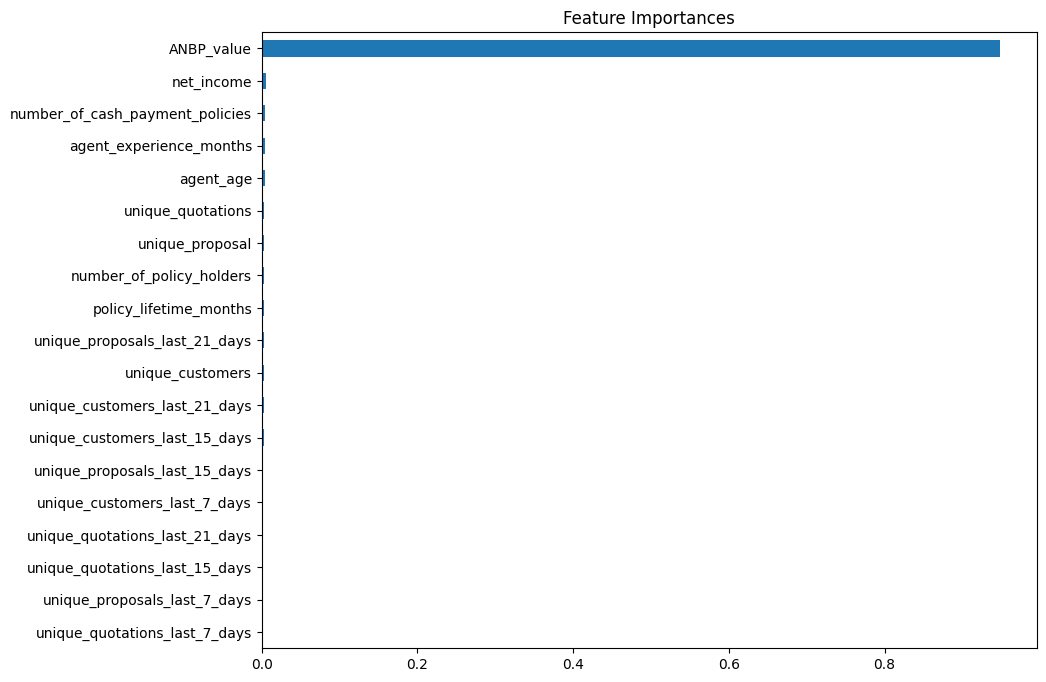

In [ ]:
# 8. Feature importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importances")
plt.show()